Import files

# **EDSA Sentiment analysis**

**by**

# **Cameron Pike**

# **Introduction**

This notebook will provide insight into the factors and opinions surrounding climate change. 
I created a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their tweet data.

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import model_selection, naive_bayes, svm

import nltk
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import urllib

from nltk.tokenize import word_tokenize as WordTokenizer


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


/kaggle/input/edsa-sentiment-classification/sample_submission.csv
/kaggle/input/edsa-sentiment-classification/train.csv
/kaggle/input/edsa-sentiment-classification/test.csv


# **Import files**

Import the files into dataframes

In [2]:

df = pd.read_csv('../input/edsa-sentiment-classification/train.csv')
df_test = pd.read_csv('../input/edsa-sentiment-classification/test.csv')
sample = pd.read_csv('../input/edsa-sentiment-classification/sample_submission.csv')


# **Exploratory Data Analysis**

View the first 5 rows of the training data

In [3]:
print(df.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


View the first 5 rows of the test data

In [4]:
print(df_test.head())

                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


View the first 5 rows of the sample data

In [5]:
print(sample.head())

   tweetid  sentiment
0   169760          1
1    35326          1
2   224985          1
3   476263          1
4   872928          1


Drop the last column of the sample data

In [6]:
#Drop sentiment column in sample. We will add the predicted sentiment later
sample = sample.iloc[: , :-1]
print(sample.head())

   tweetid
0   169760
1    35326
2   224985
3   476263
4   872928


Analyse the columns, shape and data types in the training data

In [7]:
print("Columns in train")
print(df.columns)

print("Shape of train")
print(df.shape)

print("Info of train")
print(df.info())

print("Data types in train")
print(df.dtypes)

#np.sum(df.isnull().any(axis=1))
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))


print("Unique sentiment values in train")
print(df['sentiment'].unique())


print("Total Unique sentiment values in train")
#Total uniques
print(df['sentiment'].nunique())




Columns in train
Index(['sentiment', 'message', 'tweetid'], dtype='object')
Shape of train
(15819, 3)
Info of train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB
None
Data types in train
sentiment     int64
message      object
tweetid       int64
dtype: object
Count of columns in the data is:   3
Count of rows in the data is:   15819
Unique sentiment values in train
[ 1  2  0 -1]
Total Unique sentiment values in train
4


Analyse the columns, shape and data types in the test data

In [8]:
print("Columns in test")
print(df_test.columns)

print("Shape of test")
print(df_test.shape)

print("Info of test")
print(df_test.info())

print("Data types in test")
print(df_test.dtypes)

#np.sum(df.isnull().any(axis=1))
print('Count of columns in the data is:  ', len(df_test.columns))
print('Count of rows in the data is:  ', len(df_test))




Columns in test
Index(['message', 'tweetid'], dtype='object')
Shape of test
(10546, 2)
Info of test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB
None
Data types in test
message    object
tweetid     int64
dtype: object
Count of columns in the data is:   2
Count of rows in the data is:   10546


Data preprocessing,

Place the training data columns into a list

In [9]:
# Storing data in lists.

message, sentiment = list(df['message']), list(df['sentiment'])

data=df[['message','sentiment']]
#print("data")
#print(data)
data_test=df_test[['message']]
#print("data_test")
#print(data_test)


# **Clean the data**

In [10]:

######################################################################################
#Clean data
#####################################################################################


#Convert upper case to lower case for training data
data['message']=data['message'].str.lower()
print("before stop words")
print(data['message'].tail())

#Convert upper case to lower case for test data
data_test['message']=data_test['message'].str.lower()
print("before stop words test data")
print(data_test['message'].tail())


###############################################
#Clean punctuation
###############################################

#Remove punctuation eg !?

english_punctuations = string.punctuation
punctuations_list = english_punctuations


def cleaning_punctuations(message):
    translator = str.maketrans('', '', punctuations_list)
    return message.translate(translator)
data['message']= data['message'].apply(lambda x: cleaning_punctuations(x))
print("punctuation")
print(data['message'].tail())

data_test['message']= data_test['message'].apply(lambda x: cleaning_punctuations(x))
print("punctuation test data")
print(data_test['message'].tail())




###############################################
#Clean repeating characters
###############################################


def cleaning_repeating_char(message):
    return re.sub(r'(.)1+', r'1', message)
data['message'] = data['message'].apply(lambda x: cleaning_repeating_char(x))
print("after repeating charss")
print(data['message'].tail())

data_test['message'] = data_test['message'].apply(lambda x: cleaning_repeating_char(x))
print("after repeating chars test data")
print(data_test['message'].tail())



###############################################
#Clean url's
###############################################


def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['message'] = data['message'].apply(lambda x: cleaning_URLs(x))
print("after clean urls")
print(data['message'].tail())

data_test['message'] = data_test['message'].apply(lambda x: cleaning_URLs(x))
print("after clean urls test data")
print(data_test['message'].tail())



###############################################
#Clean repeating numbers
###############################################


def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['message'] = data['message'].apply(lambda x: cleaning_numbers(x))
print("after clean numbers")
print(data['message'].tail())

data_test['message'] = data_test['message'].apply(lambda x: cleaning_numbers(x))
print("after clean numbers test data")
print(data_test['message'].tail())



###############################################
#Clean hashtags
###############################################


def cleaning_hastags(data):
    return re.sub('#[A-Za-z0-9_]+', '', data)
data['message'] = data['message'].apply(lambda x: cleaning_hastags(x))
print("after clean hastags")
print(data['message'].tail())

data_test['message'] = data_test['message'].apply(lambda x: cleaning_hastags(x))
print("after clean hastags test data")
print(data_test['message'].tail())



###############################################
#Clean mentions
###############################################


def cleaning_mentions(data):
    return re.sub('@[A-Za-z0-9_]+', '', data)
data['message'] = data['message'].apply(lambda x: cleaning_mentions(x))
print("after clean mentions")
print(data['message'].tail())

data_test['message'] = data_test['message'].apply(lambda x: cleaning_mentions(x))
print("after clean mentions test data")
print(data_test['message'].tail())




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

before stop words
15814    rt @ezlusztig: they took down the material on ...
15815    rt @washingtonpost: how climate change could b...
15816    notiven: rt: nytimesworld :what does trump act...
15817    rt @sara8smiles: hey liberals the climate chan...
15818    rt @chet_cannon: .@kurteichenwald's 'climate c...
Name: message, dtype: object
before stop words test data
10541    rt @brittanybohrer: brb, writing a poem about ...
10542    2016: the year climate change came home: durin...
10543    rt @loop_vanuatu: pacific countries positive a...
10544    rt @xanria_00018: you’re so hot, you must be t...
10545    rt @chloebalaoing: climate change is a global ...
Name: message, dtype: object
punctuation
15814    rt ezlusztig they took down the material on gl...
15815    rt washingtonpost how climate change could be ...
15816    notiven rt nytimesworld what does trump actual...
15817    rt sara8smiles hey liberals the climate change...
15818    rt chetcannon kurteichenwalds climate change e...

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

punctuation test data
10541    rt brittanybohrer brb writing a poem about cli...
10542    2016 the year climate change came home during ...
10543    rt loopvanuatu pacific countries positive abou...
10544    rt xanria00018 you’re so hot you must be the c...
10545    rt chloebalaoing climate change is a global is...
Name: message, dtype: object
after repeating charss
15814    rt ezlusztig they took down the material on gl...
15815    rt washingtonpost how climate change could be ...
15816    notiven rt nytimesworld what does trump actual...
15817    rt sara8smiles hey liberals the climate change...
15818    rt chetcannon kurteichenwalds climate change e...
Name: message, dtype: object
after repeating chars test data
10541    rt brittanybohrer brb writing a poem about cli...
10542    216 the year climate change came home during t...
10543    rt loopvanuatu pacific countries positive abou...
10544    rt xanria0018 you’re so hot you must be the ca...
10545    rt chloebalaoing climate chang

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

after clean urls
15814    rt ezlusztig they took down the material on gl...
15815    rt washingtonpost how climate change could be ...
15816    notiven rt nytimesworld what does trump actual...
15817    rt sara8smiles hey liberals the climate change...
15818    rt chetcannon kurteichenwalds climate change e...
Name: message, dtype: object
after clean urls test data
10541    rt brittanybohrer brb writing a poem about cli...
10542    216 the year climate change came home during t...
10543    rt loopvanuatu pacific countries positive abou...
10544    rt xanria0018 you’re so hot you must be the ca...
10545    rt chloebalaoing climate change is a global is...
Name: message, dtype: object
after clean numbers
15814    rt ezlusztig they took down the material on gl...
15815    rt washingtonpost how climate change could be ...
15816    notiven rt nytimesworld what does trump actual...
15817    rt sarasmiles hey liberals the climate change ...
15818    rt chetcannon kurteichenwalds climate chang

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

Tokenization
Word tokenization is the process of splitting a large sample of text into words. This is a requirement in natural language processing tasks where each word needs to be captured and subjected to further analysis like classifying and counting them for a particular sentiment etc. 

In [15]:
##################################################################################################
#Tokenization
#Tokenization is the process breaking complex data like paragraphs into simple units called tokens.
#
#Sentence tokenization : split a paragraph into list of sentences using sent_tokenize() method
#Word tokenization : split a sentence into list of words using word_tokenize() method
#
#Some other important terms related to word Tokenization are:
#
#Bigrams: Tokens consist of two consecutive words known as bigrams.
#
#Trigrams: Tokens consist of three consecutive words known as trigrams.
#
#Ngrams: Tokens consist of ’N’ number of consecutive words known as ngrams
#
#
###################################################################################################


data['message'] = data['message'].astype(str).apply(WordTokenizer)
print("after tokenise")
print(data['message'])

data_test['message'] = data_test['message'].astype(str).apply(WordTokenizer)
print("after tokenise test")
print(data_test['message'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


after tokenise
0        [[, 'polyscimajor, ', ,, 'epa, ', ,, 'chief, '...
1        [[, 'its, ', ,, 'not, ', ,, 'like, ', ,, 'we, ...
2        [[, 'rt, ', ,, 'rawstory, ', ,, 'researchers, ...
3        [[, 'todayinmaker, ', ,, 'wired, ', ,, 'was, '...
4        [[, 'rt, ', ,, 'soynoviodetodas, ', ,, 'its, '...
                               ...                        
15814    [[, 'rt, ', ,, 'ezlusztig, ', ,, 'they, ', ,, ...
15815    [[, 'rt, ', ,, 'washingtonpost, ', ,, 'how, ',...
15816    [[, 'notiven, ', ,, 'rt, ', ,, 'nytimesworld, ...
15817    [[, 'rt, ', ,, 'sarasmiles, ', ,, 'hey, ', ,, ...
15818    [[, 'rt, ', ,, 'chetcannon, ', ,, 'kurteichenw...
Name: message, Length: 15819, dtype: object
after tokenise test
0        [[, 'europe, ', ,, 'will, ', ,, 'now, ', ,, 'b...
1        [[, 'combine, ', ,, 'this, ', ,, 'with, ', ,, ...
2        [[, 'the, ', ,, 'scary, ', ,, 'unimpeachable, ...
3        [[, 'karoli, ', ,, 'morgfair, ', ,, 'osbornein...
4        [[, 'rt, ', ,, 'fakewillmoo

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Stopwords
Data Cleaning plays important role in NLP to remove noise from data.
Stopwords : refers to the most common words in a language (such as “the”, “a”, “an”, “in”)
which helps in formation of sentence to make sense, but these words does not provide 
any significance in language processing so remove it .

In [16]:
###################################################################################################
#Stopwords
#
#Data Cleaning plays important role in NLP to remove noise from data.
#Stopwords : refers to the most common words in a language (such as “the”, “a”, “an”, “in”)
#which helps in formation of sentence to make sense, but these words does not provide 
#any significance in language processing so remove it .
#
#You can check list of stopwords by running below code snippet :
###################################################################################################



stop_words = set(stopwords.words("english"))

def cleaning_stopwords(message):  
    return " ".join([word for word in str(message).split() if word not in stop_words])

data['message'] = data['message'].apply(lambda message: cleaning_stopwords(message))
print("after stop words")
print(data['message'].head(20))

data_test['message'] = data_test['message'].apply(lambda message: cleaning_stopwords(message))
print("after stop words test data")
print(data_test['message'].head(20))

after stop words
0     ['[', "'polyscimajor", "'", ',', "'epa", "'", ...
1     ['[', "'its", "'", ',', "'not", "'", ',', "'li...
2     ['[', "'rt", "'", ',', "'rawstory", "'", ',', ...
3     ['[', "'todayinmaker", "'", ',', "'wired", "'"...
4     ['[', "'rt", "'", ',', "'soynoviodetodas", "'"...
5     ['[', "'worth", "'", ',', "'", 'a', "'", ',', ...
6     ['[', "'rt", "'", ',', "'thenation", "'", ',',...
7     ['[', "'rt", "'", ',', "'makeandmendlife", "'"...
8     ['[', "'aceofspadeshq", "'", ',', "'my", "'", ...
9     ['[', "'rt", "'", ',', "'paigetweedy", "'", ',...
10    ['[', "'rt", "'", ',', "'stephenschlegel", "'"...
11    ['[', "'", 'i', "'", ',', "'do", "'", ',', "'h...
12    ['[', "'rt", "'", ',', "'tveitdal", "'", ',', ...
13    ['[', "'rt", "'", ',', "'alifaith", "'", ',', ...
14    ['[', "'fossil", "'", ',', "'fuel", "'", ',', ...
15    ['[', "'rt", "'", ',', "'glblctzn", "'", ',', ...
16    ['[', "'rt", "'", ',', "'jackholmes", "'", ','...
17    ['[', "'rt", "'", ',', "'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PorterStemmer
Stemming is the process of producing morphological variants of a root/base word.
Stemming programs are commonly referred to as stemming algorithms or stemmers.
A stemming algorithm reduces the words “chocolates”, “chocolatey”, and “choco” to the root word, “chocolate”


In [13]:

###################################################################################################
#PorterStemmer
#
#Stemming is the process of producing morphological variants of a root/base word.
#Stemming programs are commonly referred to as stemming algorithms or stemmers.
#A stemming algorithm reduces the words “chocolates”, “chocolatey”, and “choco” to the root
#word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve
###################################################################################################


st = nltk.PorterStemmer()

def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['message']= data['message'].apply(lambda x: stemming_on_text(x))
print("after porter stemmer")
print(data['message'].tail())

data_test['message']= data_test['message'].apply(lambda x: stemming_on_text(x))
print("after porter stemmer test data")
print(data_test['message'].tail())


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


after porter stemmer
15814    ['rt', 'ezlusztig', 'they', 'took', 'down', 't...
15815    ['rt', 'washingtonpost', 'how', 'climate', 'ch...
15816    ['notiven', 'rt', 'nytimesworld', 'what', 'doe...
15817    ['rt', 'sarasmiles', 'hey', 'liberals', 'the',...
15818    ['rt', 'chetcannon', 'kurteichenwalds', 'clima...
Name: message, dtype: object
after porter stemmer test data
10541    ['rt', 'brittanybohrer', 'brb', 'writing', 'a'...
10542    ['the', 'year', 'climate', 'change', 'came', '...
10543    ['rt', 'loopvanuatu', 'pacific', 'countries', ...
10544    ['rt', 'xanria', 'you', '’', 're', 'so', 'hot'...
10545    ['rt', 'chloebalaoing', 'climate', 'change', '...
Name: message, dtype: object


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Lemmatization
Major drawback of stemming is it produces Intermediate representation of word. Stemmer may or may not return meaningful word.

To overcome this problem Lemmatization comes into picture.

Stemming algorithm works by cutting suffix or prefix from the word.On the contrary Lemmatization consider morphological analysis of the words and returns meaningful word in proper form.

Hence,lemmatization is preferred.

In [17]:

#######################################################################################################
#Lemmatization
#Major drawback of stemming is it produces Intermediate representation of word. Stemmer may or may not return meaningful word.
#
#To overcome this problem Lemmatization comes into picture.
#
#Stemming algorithm works by cutting suffix or prefix from the word.On the contrary Lemmatization consider morphological analysis of the words and returns meaningful word in proper form.
#
#Hence,lemmatization is preferred.
#########################################################################################################


lm = nltk.WordNetLemmatizer()

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['message'] = data['message'].apply(lambda x: lemmatizer_on_text(x))
print("after lemmatizer")
print(data['message'].tail())

data_test['message'] = data_test['message'].apply(lambda x: lemmatizer_on_text(x))
print("after lemmatizer test data")
print(data_test['message'].tail())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


after lemmatizer
15814    ['[', "'rt", "'", ',', "'ezlusztig", "'", ',',...
15815    ['[', "'rt", "'", ',', "'washingtonpost", "'",...
15816    ['[', "'notiven", "'", ',', "'rt", "'", ',', "...
15817    ['[', "'rt", "'", ',', "'sarasmiles", "'", ','...
15818    ['[', "'rt", "'", ',', "'chetcannon", "'", ','...
Name: message, dtype: object
after lemmatizer test data
10541    ['[', "'rt", "'", ',', "'brittanybohrer", "'",...
10542    ['[', "'the", "'", ',', "'year", "'", ',', "'c...
10543    ['[', "'rt", "'", ',', "'loopvanuatu", "'", ',...
10544    ['[', "'rt", "'", ',', "'xanria", "'", ',', "'...
10545    ['[', "'rt", "'", ',', "'chloebalaoing", "'", ...
Name: message, dtype: object


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# **Modeling**

TF-IDF stands for Term Frequency-Inverse Document Frequency
“Term frequency–inverse document frequency, is a numerical statistic that is intended to 
reflect how important a word is to a document in a collection or corpus.”

Term Frequency: is a scoring of the frequency of the word in the current document.
Inverse Document Frequency: is a scoring of how rare the word is across documents.
TF-IDF model contains information on the more important words and the less important ones as well.


In [19]:
###########################################################################################
#TF-IDF stands for Term Frequency-Inverse Document Frequency
#“Term frequency–inverse document frequency, is a numerical statistic that is intended to 
#reflect how important a word is to a document in a collection or corpus.”
#
#Term Frequency: is a scoring of the frequency of the word in the current document.
#Inverse Document Frequency: is a scoring of how rare the word is across documents.
#TF-IDF model contains information on the more important words and the less important ones as well.
#
#Note:In order to use TF-IDF we must pass Strings instead of tokens.
#we can use detokenizer or join method to join all tokens of list into a single string
#################################################################################################


#Split data into X and Y to create seperate target
X=data.message
y=data.sentiment
competion_test=data_test.message



# Separating the data for training data and for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =42)



vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))


print('X_train before vectoriser.transform X_train')
print(X_train)

X_train = vectoriser.transform(X_train)
print('X_train after vectoriser.transform X_train')
print(X_train)

X_test  = vectoriser.transform(X_test)
print('X_test after vectoriser.transform X_test')
print(X_test)

#Our sample from competition to predict on
X_test_sample  = vectoriser.transform(competion_test)
print('X_test_sample after vectoriser.transform data_test')
print(X_test_sample)

No. of feature_words:  140016
X_train before vectoriser.transform X_train
8249     ['[', "'on", "'", ',', "'climate", "'", ',', "...
4822     ['[', "'rt", "'", ',', "'stevesgoddard", "'", ...
13862    ['[', "'rt", "'", ',', "'cookiebo", "'", ',', ...
7759     ['[', "'rt", "'", ',', "'wickedbeaute", "'", '...
8953     ['[', "'rt", "'", ',', "'sensanders", "'", ','...
                               ...                        
13418    ['[', "'rt", "'", ',', "'safeagai", "'", ',', ...
5390     ['[', "'rt", "'", ',', "'businessinsider", "'"...
860      ['[', "'rt", "'", ',', "'bramnessellen", "'", ...
15795    ['[', "'china", "'", ',', "'", '’', "'", ',', ...
7270     ['[', "'rt", "'", ',', "'climatecentral", "'",...
Name: message, Length: 15028, dtype: object
X_train after vectoriser.transform X_train
  (0, 133697)	0.2567699012185734
  (0, 133662)	0.15239565557871654
  (0, 128604)	0.20642513448110705
  (0, 128603)	0.20642513448110705
  (0, 119019)	0.14817950555839499
  (0, 118527)	0.05116

Performance evaluation of models

In [20]:
##########################################################################
#Train and evaluate models
#################################################################


def model_Evaluate(model):
 # Predict values for Test dataset
 y_pred = model.predict(X_test)
 print("y predict")
 print(y_pred)
 # Print the evaluation metrics for the dataset.
 print(classification_report(y_test, y_pred))
 # Compute and plot the Confusion matrix
 cf_matrix = confusion_matrix(y_test, y_pred)

    
#BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
print("score for BNB")
model_Evaluate(BNBmodel)

y_pred_final_BNB = BNBmodel.predict(X_test_sample)
print("y predict final BNB")
print(y_pred_final_BNB)

#Add extra column to output
#Copy the sample file
sample_BNB_copy = sample.copy()
sample_BNB_copy['sentiment'] = y_pred_final_BNB
sample_BNB_copy[['tweetid','sentiment']].to_csv('testsubmission_BNB.csv', index=False)


#LinearSVC
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
print("score for svc")
model_Evaluate(SVCmodel)

y_pred_final_SVC = SVCmodel.predict(X_test_sample)
print("y predict final SVC")
print(y_pred_final_SVC)

#Add extra column to output
#Copy the sample file
sample_SVC_copy = sample.copy()
sample_SVC_copy['sentiment'] = y_pred_final_SVC
sample_SVC_copy[['tweetid','sentiment']].to_csv('testsubmission_SVC.csv', index=False)



#Logistic Regression
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
print("score for LRmodel")
model_Evaluate(LRmodel)

y_pred_final_LR = LRmodel.predict(X_test_sample)
print("y predict final LR")
print(y_pred_final_LR)

#Add extra column to output
#Copy the sample file
sample_LR_copy = sample.copy()
sample_LR_copy['sentiment'] = y_pred_final_LR
sample_LR_copy[['tweetid','sentiment']].to_csv('testsubmission_LR.csv', index=False)




#RandomForestClassifier()
RFCmodel = RandomForestClassifier()
RFCmodel.fit(X_train, y_train)
print("score for RFCmodel")
model_Evaluate(RFCmodel)

y_pred_final_RFC = RFCmodel.predict(X_test_sample)
print("y predict final RFC")
print(y_pred_final_RFC)

#Add extra column to output
#Copy the sample file
sample_RFC_copy = sample.copy()
sample_RFC_copy['sentiment'] = y_pred_final_RFC
sample_RFC_copy[['tweetid','sentiment']].to_csv('testsubmission_RFC.csv', index=False)


score for BNB
y predict
[1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


score for svc
y predict
[ 1  2  1 -1  0 -1  1  1  1  1 -1  1  2  0  2  1  2  1  1  1  1  1  1  1
  1  2  2  1  0  1  1  1  1  1  1  1  1  1  1  1  1  0  2  2 -1 -1  1  1
  1  2  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1
  2  1  1  1  1  1  2  1  1  1  1  1  2  1 -1  1  1  2  2  1  1  1  2  0
  0 -1  2  0  1  1  0  1  2  1  1  1  1  0  1  1  2  1  0  1  1  1  2  1
  1  2  1  1  2 -1  1  2  1  0  2  1  2  2  2  1  2  2  1  1  1  1  2  2
  2  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  0  1  1  1  1  1  1
  2  1  1  2 -1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  2  1 -1  2  1
 -1  2 -1  1  1  2  1  1  1  0  1 -1  0  2  1  1  1  1  2  0  2  1  2  1
  2  1  1  1  2  2  1  1  1  1  0  1  1  1  0  2  1  1  2  0  1  1  1  1
  1  1  1  1  1  1  1  0  1  1  2  2  2  1  1  1  1  1  1  0  0  1  2  0
  1  0  1  0  1  1  1  2  1  2  1  1  1  2  1  0 -1  2  0  1  1 -1  1  1
 -1  1  0  1  1  2  1  2  1  1  1  1  1  1  0  1 -1  1  1 -1  1  2  1  1
  1  2  1  1  1  1  0  1  1

Visualiztions

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


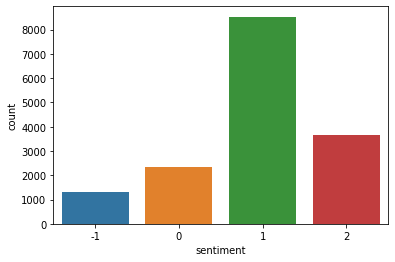

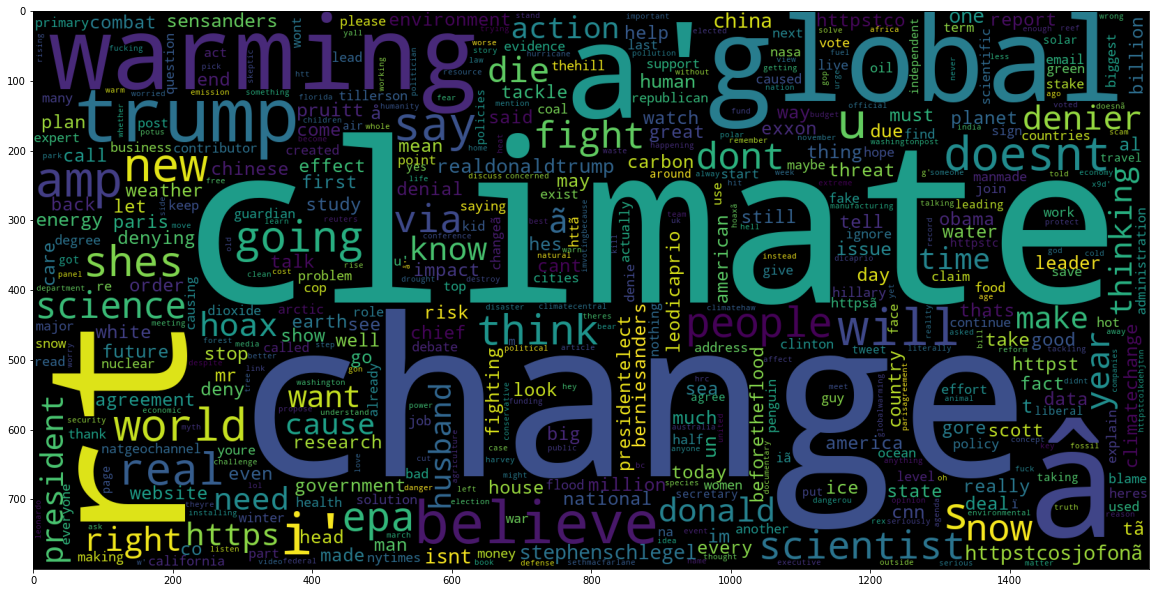

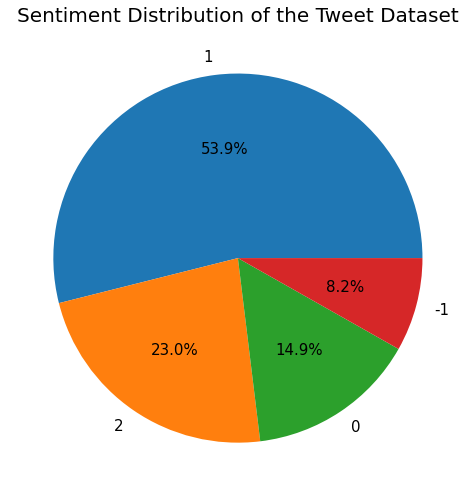

In [21]:
############################################################################
#Graphs
##########################################################################


sns.countplot(x='sentiment', data=df)



#data_neg = data['message'][:500]
data_neg = X[:15818]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)





# set up label dataframe for future refrences
'''
label = [-1, 0, 1, 2]
labelN = ["Against", "Neutral", "Pro", "FactualNews"]
labelDesc = [
    "the tweet does not believe in man-made climate change"
    , "the tweet neither supports nor refutes the belief of man-made climate change"
    , "the tweet supports the belief of man-made climate change"
    , "the tweet links to factual news about climate change"
]

dfLabel = pd.DataFrame(list(zip(label, labelN, labelDesc)), columns=["label", "sentiment", "description"])
'''
print(df.head())

plt.figure(figsize = (7, 7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()
